In [1]:
# I switched to 2.7 for processing/EDA temporarily to try https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction

import keras
import tensorflow as tf
import pylab
import imageio
import ffmpy
import numpy as np
from numpy import fft as fft
from scipy.fftpack import fft, ifft, rfft, irfft, fftfreq
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
import scipy.io.wavfile
from scipy import signal as signal
from scipy.signal import butter, lfilter
from pylab import *
import IPython.display

# Pyfasst
import setuptools
from distutils.core import setup
from distutils.extension import Extension
import pyfasst.audioModel as am

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display
from __future__ import print_function

Using TensorFlow backend.


Using scipy.io.wavfile


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pyfasst/tftransforms/nsgt/__init__.py:37: UserWarning: Audio IO routines (scikits.audio module) could not be imported
  warn("Audio IO routines (scikits.audio module) could not be imported")


## Early playing around with tools. This generates snapshots.

In [2]:
# # Playing around with snapshots: https://stackoverflow.com/questions/29718238/how-to-read-mp4-video-to-be-processed-by-scikit-image

# filename = 'mal_eng_1st_half_eng.mp4'
# vid = imageio.get_reader(filename,  'ffmpeg')
# nums = [1,30,60,90,120]
# for num in nums:
#     image = vid.get_data(num)
#     fig = pylab.figure()
#     fig.suptitle('image #{}'.format(num), fontsize=20)
#     pylab.imshow(image)
# pylab.show()

In [3]:
# This is really about framerates and not terribly useful but still kind of interesting.

# for i, im in enumerate(vid):
#     print('Mean of frame %i is %1.1f' % (i, im.mean()))

In [4]:
# ff = ffmpy.FFmpeg(
#     inputs={'mal_eng_1st_half_eng.mp4': None},
#     outputs={'output.avi': None}
# )
# ff.run()

## Early playing around with frequency and amplitude and track division. Used this in first baseline.

In [5]:
# #http://myinspirationinformation.com/uncategorized/audio-signals-in-python/
# from scipy.io.wavfile import read
# samprate, wavdata = read('output_audio.wav')

In [6]:
# print(samprate)

In [7]:
# print(wavdata)

In [8]:
# wavdata.shape[0] / samprate

In [9]:
# wavdata.shape[1]

In [10]:
# channel1=wavdata[:,0] #left
# channel2=wavdata[:,1] #right

In [11]:
# wavdata.dtype

In [12]:
# np.sum(channel1.astype(float)**2)

In [13]:
# 1.0/(2*(channel1.size)+1)*np.sum(channel1.astype(float)**2)/samprate

In [14]:
# time = np.arange(0, float(wavdata.shape[0]), 1) / samprate

In [15]:
# #plot amplitude (or loudness) over time -- could convert this to dbs with 'dB = 20 * log10(amplitude)'
# plt.figure(1)
# plt.subplot(211)
# plt.plot(time, channel1, linewidth=0.01, alpha=0.7, color='#ff7f00')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.subplot(212)
# plt.plot(time, channel2, linewidth=0.01, alpha=0.7, color='#ff7f00')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.show()

In [16]:
# #This doesn't chart for some reason. Should chart frequency.
# fourier=np.fft.fft(channel1)

# plt.plot(fourier, color='#ff7f00')
# plt.xlabel('k')
# plt.ylabel('Amplitude')
# plt.show()

## This was my first and simplistic attempt to separate sound types. It generated some very static-y stuff.

In [17]:
# #how do we take channel1 and create a high and a low based on fft? https://stackoverflow.com/questions/19122157/fft-bandpass-filter-in-python

# time   = np.arange(0, float(wavdata.shape[0]), 1) / samprate
# signal = channel1

# W = fftfreq(signal.size, d=time[1]-time[0])
# f_signal = rfft(signal)

# # If our original signal time was in seconds, this is now in Hz    
# cut_f_signal = f_signal.copy()
# cut_f_signal[(W>20000)] = 0

# cut_signal = irfft(cut_f_signal)

In [18]:
# plt.subplot(221)
# plt.plot(time,signal)
# plt.subplot(222)
# plt.plot(W,f_signal)
# plt.xlim(0,10)
# plt.subplot(223)
# plt.plot(W,cut_f_signal)
# plt.xlim(0,10)
# plt.subplot(224)
# plt.plot(time,cut_signal)
# plt.show()

In [19]:
# channel1low = signal
# channel1high = cut_signal

In [20]:
# scipy.io.wavfile.write('channel1low2.wav',samprate,channel1low)
# scipy.io.wavfile.write('channel1high2.wav',samprate,channel1high)

## This never worked at all.

In [21]:
# https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.signal.fftconvolve.html

# autocorr = signal.fftconvolve(channel1, channel1[::-1], mode='full')
# fig, (ax_orig, ax_mag) = plt.subplots(2, 1)
# ax_orig.plot(channel1)
# ax_orig.set_title('White noise')
# ax_mag.plot(np.arange(-len(channel1)+1,len(channel1)), autocorr)
# ax_mag.set_title('Autocorrelation')
# fig.tight_layout()
# fig.show()
# plt.show()

In [22]:
# https://dsp.stackexchange.com/questions/2885/beginner-attempting-fft-signal-filtering-with-numpy
# http://mpastell.com/2010/01/18/fir-with-scipy/

# def firfilt(interval, freq, sampling_rate):
#     nfreq = freq/(0.5*sampling_rate)
#     taps =  sampling_rate + 1
#     a = 1
#     b = scipy.signal.firwin(taps, cutoff=nfreq)
#     return scipy.signal.lfilter(b, a, interval)

## This was my attempt to get Pyfasst up and running. The technology has promise if we can get it working but it hasn't been supported in many years and I'm hitting errors that are likely more trouble than they are worth.

In [23]:
# # Attempting to try FASST

# import pyfasst.audioModel as am
# filename = '/Users/brianschneider/Downloads/pyFASST-0.9.3/data/tamy.wav'
# model = am.MultiChanNMFInst_FASST(
#     audio=filename,
#     nbComps=2, nbNMFComps=32, spatial_rank=1,
#     verbose=1, iter_num=50)
# # estimate the parameters
# model.estim_param_a_post_model()
# # separate the sources using these parameters
# model.separate_spat_comps(dir_results='data/')

In [24]:
# filename = '/Users/brianschneider/Desktop/capstone/gameSummarizer/output_audio.wav'
# # initialize the model
# model = am.MultiChanNMFConv(
#     audio=filename,
#     nbComps=2, nbNMFComps=32, spatial_rank=1,
#     verbose=1, iter_num=200)
# # to be more flexible, the user _has to_ make the parameters
# # convolutive by hand. This way, she can also start to estimate
# # parameters in an instantaneous setting, as an initialization,
# # and only after "upgrade" to a convolutive setting:
# model.makeItConvolutive()
# # we can initialize these parameters with the DEMIX algorithm:
# model.initializeConvParams(initMethod='demix')
# # and estimate the parameters:
# model.estim_param_a_post_model()
# # separate the sources using these parameters
# model.separate_spat_comps(dir_results='data/')

In [25]:
# import pyfasst.audioModel as am
# filename = '/Users/brianschneider/Desktop/capstone/gameSummarizer/output_audio.wav'
# # initialize the model
# model = am.MultiChanNMFConv(
#     audio=filename,
#     nbComps=2, nbNMFComps=32, spatial_rank=1,
#     verbose=1, iter_num=200)
# # to be more flexible, the user _has to_ make the parameters
# # convolutive by hand. This way, she can also start to estimate
# # parameters in an instantaneous setting, as an initialization,
# # and only after "upgrade" to a convolutive setting:
# model.makeItConvolutive()
# # we can initialize these parameters with the DEMIX algorithm:
# model.initializeConvParams(initMethod='demix')
# # and estimate the parameters:
# model.estim_param_a_post_model()
# # separate the sources using these parameters
# model.separate_spat_comps(dir_results='data/')

## These were early FFT forays that failed.

In [26]:
# n = len(channel1)
# fourier = fourier[0:(n/2)]

# # scale by the number of points so that the magnitude does not depend on the length
# fourier = fourier / float(n)

# #calculate the frequency at each point in Hz
# freqArray = np.arange(0, (n/2), 1.0) * (samprate*1.0/n);

# plt.plot(freqArray/1000, 10*np.log10(fourier), color='#ff7f00', linewidth=0.02)
# plt.xlabel('Frequency (kHz)')
# plt.ylabel('Power (dB)')

In [27]:
# fourier2 = np.fft.fft(channel2)
# # plt.plot(fourier, color='#ff7f00')
# plt.plot(np.real(fourier2),'wo')
# # plt.plot(np.imag(fourier),'wo')
# # plt.xlabel('k')
# # plt.ylabel('Amplitude')
# plt.show()

## This is actually a continuation of the channel amplitude/frequency work that generates the second half of the game I was testing.

In [28]:
# #2nd half
# from scipy.io.wavfile import read
# samprate2, wavdata2 = read('output_audio2.wav')

In [29]:
# channel3=wavdata2[:,0] #left
# channel4=wavdata2[:,1] #right

In [30]:
# time2 = np.arange(0, float(wavdata2.shape[0]), 1) / samprate2

In [31]:
# #plot amplitude (or loudness) over time -- could convert this to dbs with 'dB = 20 * log10(amplitude)'
# plt.figure(1)
# plt.subplot(211)
# plt.plot(time2, channel3, linewidth=0.01, alpha=0.7, color='#ff7f00')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.subplot(212)
# plt.plot(time2, channel4, linewidth=0.01, alpha=0.7, color='#ff7f00')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.show()

## BASELINE

This was our baseline case, with help from Zulko.

In [32]:
# # http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/

# import numpy as np # for numerical operations
# from moviepy.editor import VideoFileClip, concatenate

# clip = VideoFileClip("/Users/brianschneider/Desktop/capstone/gameSummarizer/mal_eng_1st_half_eng.mp4")
# cut = lambda i: clip.audio.subclip(i,i+1).to_soundarray(fps=22000)
# volume = lambda array: np.sqrt(((1.0*array)**2).mean())
# volumes = [volume(cut(i)) for i in range(0,int(clip.duration-1))]

In [33]:
# averaged_volumes = np.array([sum(volumes[i:i+10])/10
#                              for i in range(len(volumes)-10)])

In [34]:
# increases = np.diff(averaged_volumes)[:-1]>=0
# decreases = np.diff(averaged_volumes)[1:]<=0
# peaks_times = (increases * decreases).nonzero()[0]
# peaks_vols = averaged_volumes[peaks_times]
# peaks_times = peaks_times[peaks_vols>np.percentile(peaks_vols,90)]

In [35]:
# final_times=[peaks_times[0]]
# for t in peaks_times:
#     if (t - final_times[-1]) < 60:
#         if averaged_volumes[t] > averaged_volumes[final_times[-1]]:
#             final_times[-1] = t
#     else:
#         final_times.append(t)

In [36]:
# final = concatenate([clip.subclip(max(t-5,0),min(t+5, clip.duration))
#                      for t in final_times])
# final.write_videofile('/Users/brianschneider/Desktop/capstone/gameSummarizer/highlights.mp4', 
#   codec='libx264', 
#   audio_codec='aac', 
#   temp_audiofile='temp-audio.m4a', 
#   remove_temp=True)

## This will be Librosa.

In [37]:
# from __future__ import print_function

In [38]:
audio_path = '/Users/brianschneider/Desktop/capstone/gameSummarizer/output_audio.wav'
y, sr = librosa.load(audio_path, duration=120)

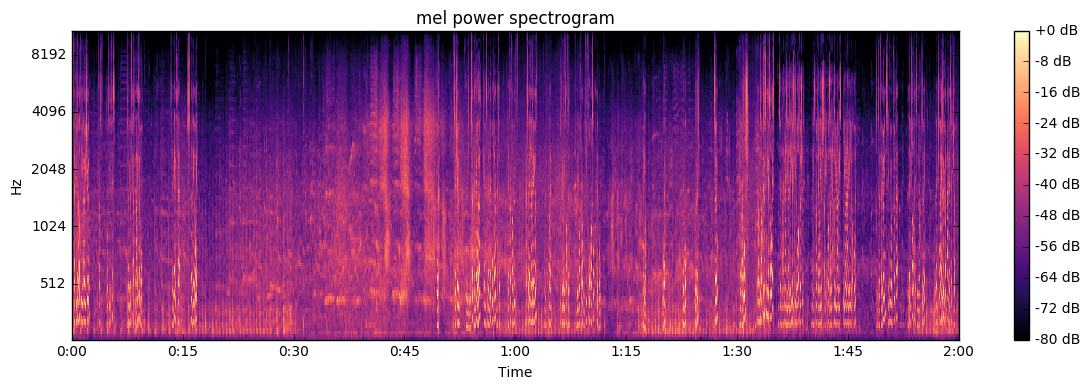

In [39]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

In [40]:
# Source separation

y_harmonic, y_percussive = librosa.effects.hpss(y)

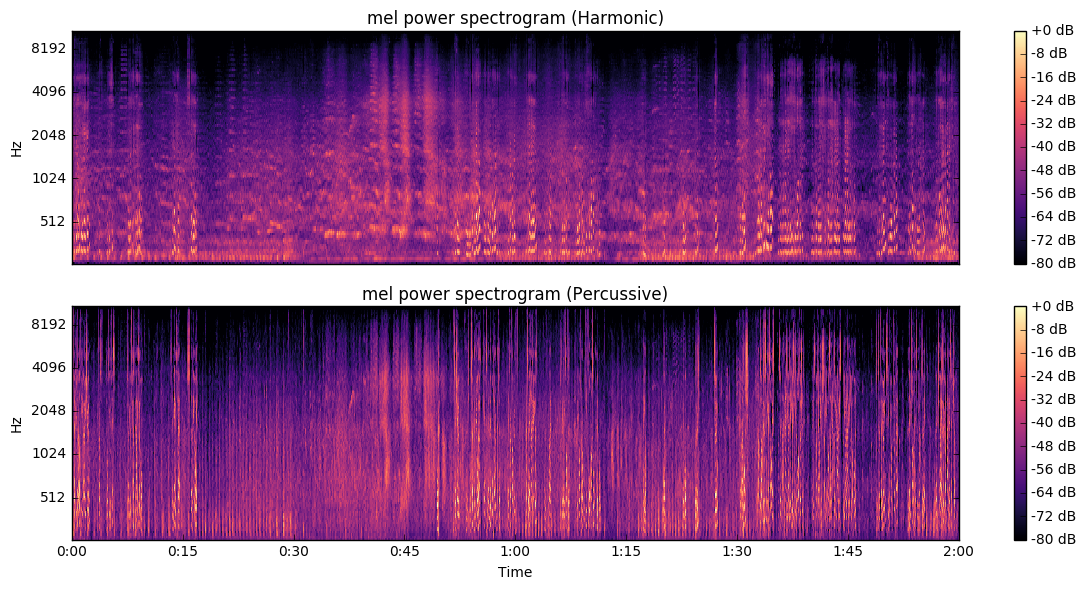

In [41]:
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

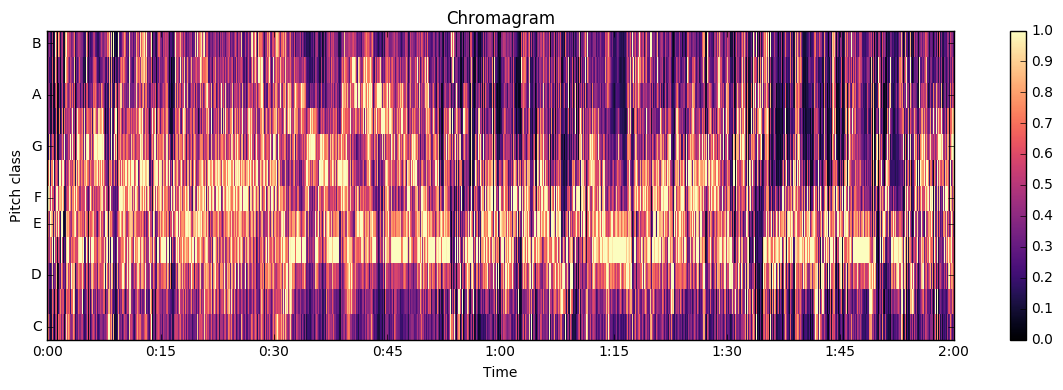

In [42]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

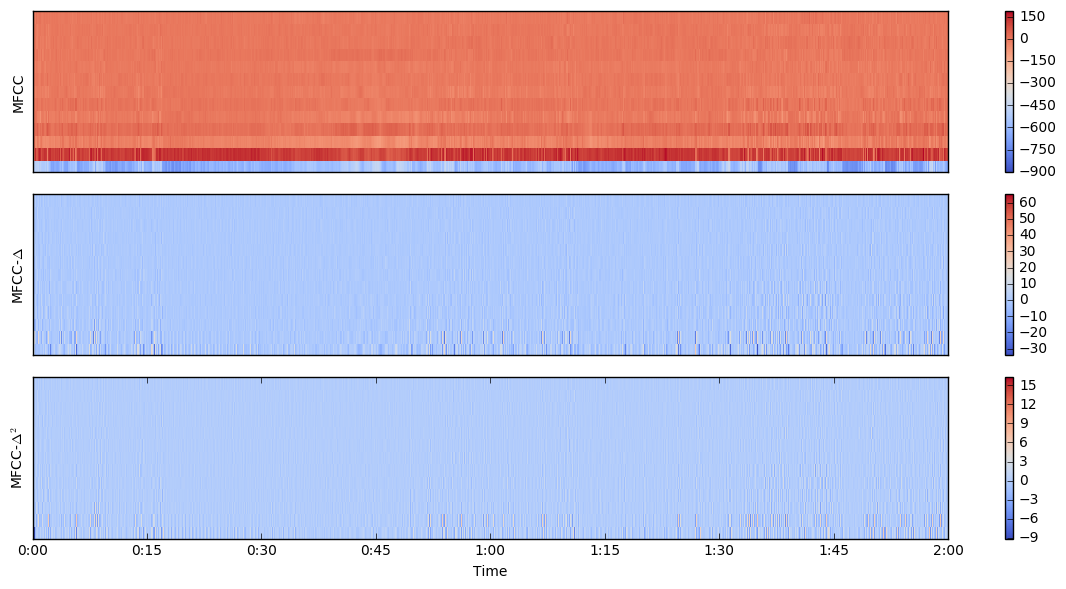

In [43]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

In [44]:
# # Now, let's run the beat tracker.
# # We'll use the percussive component for this part
# plt.figure(figsize=(12, 6))
# tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

# # Let's re-draw the spectrogram, but this time, overlay the detected beats
# plt.figure(figsize=(12,4))
# librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# # Let's draw transparent lines over the beat frames
# plt.vlines(librosa.frames_to_time(beats),
#            1, 0.5 * sr,
#            colors='w', linestyles='-', linewidth=2, alpha=0.5)

# plt.axis('tight')

# plt.colorbar(format='%+02.0f dB')

# plt.tight_layout()

In [45]:
# # feature.sync will summarize each beat event by the mean feature vector within that beat

# M_sync = librosa.util.sync(M, beats)

# plt.figure(figsize=(12,6))

# # Let's plot the original and beat-synchronous features against each other
# plt.subplot(2,1,1)
# librosa.display.specshow(M)
# plt.title('MFCC-$\Delta$-$\Delta^2$')

# # We can also use pyplot *ticks directly
# # Let's mark off the raw MFCC and the delta features
# plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

# plt.colorbar()

# plt.subplot(2,1,2)
# # librosa can generate axis ticks from arbitrary timestamps and beat events also
# librosa.display.specshow(M_sync, x_axis='time',
#                          x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

# plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
# plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
# plt.colorbar()

# plt.tight_layout()

In [46]:
# # Beat synchronization is flexible.
# # Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# # We can replace the mean with any statistical aggregation function, such as min, max, or median.

# C_sync = librosa.util.sync(C, beats, aggregate=np.median)

# plt.figure(figsize=(12,6))

# plt.subplot(2, 1, 1)
# librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

# plt.title('Chroma')
# plt.colorbar()

# plt.subplot(2, 1, 2)
# librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
#                          x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


# plt.title('Beat-synchronous Chroma (median aggregation)')

# plt.colorbar()
# plt.tight_layout()

In [47]:
# Play it back!
# IPython.display.Audio(data=y, rate=sr)

In [48]:
# How about separating harmonic and percussive components?
y_h, y_p = librosa.effects.hpss(y)

In [49]:
# Play the harmonic component
# IPython.display.Audio(data=y_h, rate=sr)
maxv = np.iinfo(np.int16).max
librosa.output.write_wav(
    "out_int16Harmonic.wav", (y_h * maxv).astype(np.int16), sr
)

In [50]:
# Play the percussive component
# IPython.display.Audio(data=y_p, rate=sr)
maxv = np.iinfo(np.int16).max
librosa.output.write_wav(
    "out_int16Percussive.wav", (y_p * maxv).astype(np.int16), sr
)

In [51]:
# # How about something more advanced?  Let's decompose a spectrogram with NMF, and then resynthesize an individual component
# D = librosa.stft(y)

# # Separate the magnitude and phase
# S, phase = librosa.magphase(D)

# # Decompose by nmf
# components, activations = librosa.decompose.decompose(S, n_components=8, sort=True)

In [52]:
# # Play back the reconstruction
# # Reconstruct a spectrogram by the outer product of component k and its activation
# D_k = components.dot(activations)

# # invert the stft after putting the phase back in
# y_k = librosa.istft(D_k * phase)

# # And playback
# print('Full reconstruction')

# IPython.display.Audio(data=y_k, rate=sr)

In [53]:
# # Resynthesize.  How about we isolate just first (lowest) component?
# k = 0

# # Reconstruct a spectrogram by the outer product of component k and its activation
# D_k = np.multiply.outer(components[:, k], activations[k])

# # invert the stft after putting the phase back in
# y_k = librosa.istft(D_k * phase)

# # And playback
# print('Component #{}'.format(k))

# IPython.display.Audio(data=y_k, rate=sr)

In [54]:
# # Resynthesize.  How about we isolate a middle-frequency component?
# k = len(activations) // 2

# # Reconstruct a spectrogram by the outer product of component k and its activation
# D_k = np.multiply.outer(components[:, k], activations[k])

# # invert the stft after putting the phase back in
# y_k = librosa.istft(D_k * phase)

# # And playback
# print('Component #{}'.format(k))

# IPython.display.Audio(data=y_k, rate=sr)

In [55]:
# # Resynthesize.  How about we isolate just last (highest) component?
# k = -1

# # Reconstruct a spectrogram by the outer product of component k and its activation
# D_k = np.multiply.outer(components[:, k], activations[k])

# # invert the stft after putting the phase back in
# y_k = librosa.istft(D_k * phase)

# # And playback
# print('Component #{}'.format(k))

# IPython.display.Audio(data=y_k, rate=sr)

In [56]:
D = librosa.stft(y)
D_harmonic, D_percussive = librosa.decompose.hpss(D)
D_harmonic2, D_percussive2 = librosa.decompose.hpss(D, margin=2)
D_harmonic4, D_percussive4 = librosa.decompose.hpss(D, margin=4)
D_harmonic8, D_percussive8 = librosa.decompose.hpss(D, margin=8)
D_harmonic16, D_percussive16 = librosa.decompose.hpss(D, margin=16)

In [73]:
maxv = np.iinfo(np.int16).max
librosa.output.write_wav(
    "out_int16D_percussive4.wav", (D_percussive4 * maxv).astype(np.int16), sr
)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


## https://librosa.github.io/librosa_gallery/auto_examples/plot_vocal_separation.html

Example splits vocals out. Want to try it.

In [57]:
# y, sr = librosa.load('/Users/brianschneider/Desktop/capstone/gameSummarizer/output_audio.wav', duration=120)


# # And compute the spectrogram magnitude and phase
# S_full, phase = librosa.magphase(librosa.stft(y))

In [58]:
# idx = slice(*librosa.time_to_frames([30, 35], sr=sr))
# plt.figure(figsize=(12, 4))
# librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
#                          y_axis='log', x_axis='time', sr=sr)
# plt.colorbar()
# plt.tight_layout()

In [59]:
# # We'll compare frames using cosine similarity, and aggregate similar frames
# # by taking their (per-frequency) median value.
# #
# # To avoid being biased by local continuity, we constrain similar frames to be
# # separated by at least 2 seconds.
# #
# # This suppresses sparse/non-repetetitive deviations from the average spectrum,
# # and works well to discard vocal elements.

# S_filter = librosa.decompose.nn_filter(S_full,
#                                        aggregate=np.median,
#                                        metric='cosine',
#                                        width=int(librosa.time_to_frames(2, sr=sr)))

# # The output of the filter shouldn't be greater than the input
# # if we assume signals are additive.  Taking the pointwise minimium
# # with the input spectrum forces this.
# S_filter = np.minimum(S_full, S_filter)

In [60]:
# # We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# # Note: the margins need not be equal for foreground and background separation
# margin_i, margin_v = 2, 10
# power = 2

# mask_i = librosa.util.softmask(S_filter,
#                                margin_i * (S_full - S_filter),
#                                power=power)

# mask_v = librosa.util.softmask(S_full - S_filter,
#                                margin_v * S_filter,
#                                power=power)

# # Once we have the masks, simply multiply them with the input spectrum
# # to separate the components

# S_foreground = mask_v * S_full
# S_background = mask_i * S_full

In [61]:
# # sphinx_gallery_thumbnail_number = 2

# plt.figure(figsize=(12, 8))
# plt.subplot(3, 1, 1)
# librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
#                          y_axis='log', sr=sr)
# plt.title('Full spectrum')
# plt.colorbar()

# plt.subplot(3, 1, 2)
# librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
#                          y_axis='log', sr=sr)
# plt.title('Background')
# plt.colorbar()
# plt.subplot(3, 1, 3)
# librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
#                          y_axis='log', x_axis='time', sr=sr)
# plt.title('Foreground')
# plt.colorbar()
# plt.tight_layout()
# plt.show()

In [62]:
# y, sr = librosa.load('/Users/brianschneider/Desktop/capstone/gameSummarizer/output_audio.wav') #offset=40

In [63]:
# D = librosa.stft(y)

In [64]:
# D_harmonic, D_percussive = librosa.decompose.hpss(D)

In [65]:
# # Pre-compute a global reference power from the input spectrum
# rp = np.max(np.abs(D))

# plt.figure(figsize=(12, 8))

# plt.subplot(3, 1, 1)
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis='log')
# plt.colorbar()
# plt.title('Full spectrogram')

# plt.subplot(3, 1, 2)
# librosa.display.specshow(librosa.amplitude_to_db(D_harmonic, ref=rp), y_axis='log')
# plt.colorbar()
# plt.title('Harmonic spectrogram')

# plt.subplot(3, 1, 3)
# librosa.display.specshow(librosa.amplitude_to_db(D_percussive, ref=rp), y_axis='log', x_axis='time')
# plt.colorbar()
# plt.title('Percussive spectrogram')
# plt.tight_layout()

In [66]:
# D_harmonic2, D_percussive2 = librosa.decompose.hpss(D, margin=2)
# D_harmonic4, D_percussive4 = librosa.decompose.hpss(D, margin=4)
# D_harmonic8, D_percussive8 = librosa.decompose.hpss(D, margin=8)
# D_harmonic16, D_percussive16 = librosa.decompose.hpss(D, margin=16)

In [67]:
# plt.figure(figsize=(10, 10))

# plt.subplot(5, 2, 1)
# librosa.display.specshow(librosa.amplitude_to_db(D_harmonic, ref=rp), y_axis='log')
# plt.title('Harmonic')
# plt.yticks([])
# plt.ylabel('margin=1')

# plt.subplot(5, 2, 2)
# librosa.display.specshow(librosa.amplitude_to_db(D_percussive, ref=rp), y_axis='log')
# plt.title('Percussive')
# plt.yticks([]), plt.ylabel('')

# plt.subplot(5, 2, 3)
# librosa.display.specshow(librosa.amplitude_to_db(D_harmonic2, ref=rp), y_axis='log')
# plt.yticks([])
# plt.ylabel('margin=2')

# plt.subplot(5, 2, 4)
# librosa.display.specshow(librosa.amplitude_to_db(D_percussive2, ref=rp), y_axis='log')
# plt.yticks([]) ,plt.ylabel('')

# plt.subplot(5, 2, 5)
# librosa.display.specshow(librosa.amplitude_to_db(D_harmonic4, ref=rp), y_axis='log')
# plt.yticks([])
# plt.ylabel('margin=4')

# plt.subplot(5, 2, 6)
# librosa.display.specshow(librosa.amplitude_to_db(D_percussive4, ref=rp), y_axis='log')
# plt.yticks([]), plt.ylabel('')

# plt.subplot(5, 2, 7)
# librosa.display.specshow(librosa.amplitude_to_db(D_harmonic8, ref=rp), y_axis='log')
# plt.yticks([])
# plt.ylabel('margin=8')

# plt.subplot(5, 2, 8)
# librosa.display.specshow(librosa.amplitude_to_db(D_percussive8, ref=rp), y_axis='log')
# plt.yticks([]), plt.ylabel('')

# plt.subplot(5, 2, 9)
# librosa.display.specshow(librosa.amplitude_to_db(D_harmonic16, ref=rp), y_axis='log')
# plt.yticks([])
# plt.ylabel('margin=16')

# plt.subplot(5, 2, 10)
# librosa.display.specshow(librosa.amplitude_to_db(D_percussive16, ref=rp), y_axis='log')
# plt.yticks([]), plt.ylabel('')

# plt.tight_layout()
# plt.show()

In [68]:
# IPython.display.Audio(data=D_harmonic, rate=sr)

In [69]:
# scipy.io.wavfile.write('harmonic.wav',sr,D_harmonic)
# scipy.io.wavfile.write('percussive.wav',sr,D_percussive)